In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
from collections import namedtuple, defaultdict
import itertools
from functools import partial
from operator import attrgetter
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel, LanguageModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID
from ngram import NGramModel
from train import _setup_parser

from math import exp

figsize = (12, 12)
sns.set_theme(
    rc={
        'figure.figsize': figsize,
        'axes.grid': True,
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'font.family': 'monospace',
        'font.size': 10,
    }
)

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
class SumData(namedtuple('SumDataTuple', ['cnt', 'vector', 'loss'])):
    """
    data structure to aggregate count, vector, loss
    """
    @property
    def mean_vector(self):
        return self.vector / np.expand_dims(self.cnt, -1)

    @property
    def mean_loss(self):
        return self.loss / self.cnt

    @property
    def ppl(self):
        return exp(self.mean_loss)

    def __add__(self, b):
        return SumData(
            cnt = self.cnt + b.cnt,
            vector = self.vector + b.vector,
            loss = self.loss + b.loss,
        )

    def __sub__(self, b):
        return SumData(
            cnt = self.cnt - b.cnt,
            vector = self.vector - b.vector,
            loss = self.loss - b.loss,
        )

    def to_numpy(self):
        return SumData(
            cnt = self.cnt,
            vector = self.vector.cpu().numpy(),
            loss = self.loss,
        )

def zero_sum_data(shape=()):
    return SumData(
        cnt = np.zeros(shape, dtype=int),
        vector = np.zeros(shape + (hidden_dim,)),
        loss = np.zeros(shape),
    )

def zero_sum_data_like(sum_data):
    return zero_sum_data(shape=sum_data.cnt.shape)

def zero_sum_datas_like(sum_datas):
    return [zero_sum_data_like(sum_data) for sum_data in sum_datas]

def list_add(a, b):
    return [x + y for x, y in zip(a, b)]

def list_sub(a, b):
    return [x - y for x, y in zip(a, b)]

class Item(namedtuple('ItemTuple', ['token_id', 'pos', 'values'])):
    """
    token_id: token index
    pos: pos tag
    values: list of SumData
    """

    @property
    def word(self):
        return idx2word[self.token_id]

    @property
    def prefix_str(self):
        prefix = f'{self.word:<10} {self.pos:<4}' if self.token_id >= 0 else f'{self.pos:<15}'
        return f'{prefix:<15} {self.values[0].cnt:>6}'

    @property
    def ppl_str(self):
        return f'{self.prefix_str:<22}: ' + ' '.join(f'{value.ppl:9.3f}' for value in self.values)

    @property
    def vector(self):
        return vectors[self.token_id]

In [4]:
# printing utilities

def print_perplexities(items, print_indices):
    """
    items: list of items
    print_indices: token indices to print
    """
    if not items:
        return

    for item in items:
        for value in item.values:
            assert value.cnt == item.values[0].cnt

    for idx in print_indices:
        item = items[idx]
        print(item.ppl_str)

    print()

    tot_values = zero_sum_datas_like(items[0].values)

    for item in filter(lambda item: item.token_id != PAD_TOKEN_ID, items):
        tot_values = list_add(tot_values, item.values)
    print(Item(-1, 'ppl', tot_values).ppl_str)

    for item in filter(lambda item: item.token_id == SOS_TOKEN_ID, items):
        tot_values = list_sub(tot_values, item.values)
    print(Item(-1, 'ppl_wo_sos', tot_values).ppl_str)

    for item in filter(lambda item: item.token_id == EOS_TOKEN_ID, items):
        tot_values = list_sub(tot_values, item.values)
    print(Item(-1, 'ppl_wo_sos_eos', tot_values).ppl_str)

    print()

In [5]:
# concreteness/other measures related


# copied from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
from nltk.corpus import wordnet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(word, pos):
    wordnet_pos = get_wordnet_pos(pos)
    if not wordnet_pos:
        wordnet_pos = wordnet.NOUN  # default
    return lemmatizer.lemmatize(word, pos=wordnet_pos)


class WordRatings:
    """Maintaining ratings of words."""
    def __init__(self, excel_path, word_field='Word', **kwargs):
        """Read data from excel_path."""
        self.data = pd.read_excel(excel_path, **kwargs)
        self.data.info()
        self.word_field = word_field

        self.word2row = {
            row[self.word_field].lower(): row
            for index, row in self.data.iterrows() if isinstance(row[self.word_field], str)
        }

    def word_to_row(self, word, pos):
        try:
            return self.word2row[word]
        except KeyError:
            try:
                return self.word2row[lemmatize(word, pos)]
            except KeyError:
                return None

    def item_to_field(self, item, field=None):
        if field is None:
            field = self.word_field
        row = self.word_to_row(item.word, item.pos)
        if row is None:
            return None
        return row[field]


concreteness_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/Concreteness ratings Brysbaert2014.xlsx")
norm_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/VanArsdall_Blunt_NormData.xlsx", sheet_name=1)

conc_field = 'Conc.M'

def pos_mapping(pos):
    pos = pos[:2]
    return pos


item_cont_fn_dict = {
    'pos': (lambda item: item.pos, False),
    'po': (lambda item: pos_mapping(item.pos), False),
    'loss': (lambda item: item.values[0].mean_loss, True),
    'loss diff': (lambda item: item.values[1].mean_loss - item.values[0].mean_loss, True),
    conc_field: (partial(concreteness_data.item_to_field, field=conc_field), True),
}

def item_cont_fn(field):
    if field in item_cont_fn_dict:
        return item_cont_fn_dict[field]
    return partial(norm_data.item_to_field, field=field), field not in {'Category'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39954 entries, 0 to 39953
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Word           39953 non-null  object 
 1   Bigram         39954 non-null  int64  
 2   Conc.M         39954 non-null  float64
 3   Conc.SD        39954 non-null  float64
 4   Unknown        39954 non-null  int64  
 5   Total          39954 non-null  int64  
 6   Percent_known  39954 non-null  float64
 7   SUBTLEX        39954 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          1200 non-null   object 
 1   Category      1200 non-null   object 
 2   Living        1200 non-null   int64  
 3   Thought       1200 non-null   int64  
 4   Repro         1200 n

In [6]:
# plotting utilities


def filter_items(items, filter_fn=lambda item: item.values[0].cnt > 0):
    original_n_items = len(items)
    items = list(filter(filter_fn, items))
    n_items = len(items)
    print(f'filtered {n_items} / {original_n_items} = {n_items/original_n_items:.2%} items.')
    return items


def plot_dendrogram(items):
    """
    linkage clustering and dendrogram plotting
    items: list of Item containing n_items items
    """
    from scipy.cluster.hierarchy import dendrogram, linkage

    n_items = len(items)
    vectors = np.array([item.vector for item in items])

    Z = linkage(vectors, method='average', metric='cosine')  # of shape (number of merges = n_items - 1, 4)

    def llf(index):
        if index < n_items:
            item = items[index]
            return item.prefix_str + ' ' + (f'{item.values[0].ppl:8.2f}' if len(item.values) == 1 else f'{item.values[0].ppl:8.2f}{item.values[1].ppl - item.values[0].ppl:+9.2f}')
        else:
            merge_index = index - n_items
            return f'{merge_index} {int(Z[merge_index, 3])} {Z[merge_index, 2]:.3f}'

    p = 10000

    plt.figure(figsize=(25 / 2, 0.3 * min(p, n_items))) # 0.1
    return dendrogram(
        Z,
        truncate_mode='lastp',
        p=p,
        orientation='left',
        leaf_rotation=0.,
        leaf_font_size=16.,
        leaf_label_func=llf,
    )

def get_tsne_points_from_vectors(vectors):
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate='auto', n_iter=1000, metric='cosine')
    points = tsne.fit_transform(vectors)
    print('T-SNE done.')
    return points

def get_tsne_points(items):
    vectors = np.array([item.vector for item in items])

    points = get_tsne_points_from_vectors(vectors)

    for item, point in zip(items, points):
        item.point = point


def plot_tsne(items, hue_name, palette=None, add_word=True):
    """t-SNE
    items: list of Item containing n_items items
    """
    hue_fn, hue_cont = item_cont_fn(hue_name)
    if palette is None:
        palette = None if hue_cont else 'tab20'

    items = filter_items(items)

    df = pd.DataFrame([item.point for item in items])
    df['word'] = [item.word for item in items]
    df[hue_name] = [hue_fn(item) for item in items]
    sns.scatterplot(data=df, x=0, y=1, hue=hue_name, palette=palette)
    if add_word:
        for item in items:
            plt.text(item.point[0], item.point[1], item.word)

def plot_xy(items, x_name, y_name, hue_name, palette=None, add_word=False):
    """plot the relation between x and y
    items: list of Item containing n_items items
    x_name, y_name: name of the value to plot as the x and y axis
    add_word: whether to add word text along with the dots
    """
    x_fn, x_cont = item_cont_fn(x_name)
    y_fn, y_cont = item_cont_fn(y_name)
    hue_fn, hue_cont = item_cont_fn(hue_name)
    if palette is None:
        palette = None if hue_cont else 'tab20'

    data = []
    ignored_items = []
    for item in items:
        x = x_fn(item)
        y = y_fn(item)
        if x is None or y is None:
            ignored_items.append(item)
        else:
            data.append((item.word, hue_fn(item), x, y))

    print('ignored items sample:', ' '.join([item.word for item in ignored_items[:100]]))

    print(f'plotting {len(data)}/{len(items)} = {len(data) / len(items):.2%} items...')
    df = pd.DataFrame(data, columns=['word', hue_name, x_name, y_name])
    g = sns.relplot(data=df, x=x_name, y=y_name, hue=hue_name, palette=palette)
    g.figure.set_size_inches(*figsize)
    if add_word:
        for _, row in df.iterrows():
            plt.text(row[x_name], row[y_name], row['word'])

In [7]:
# get counts, vectors, losses, pos tags

from tqdm import tqdm


def build_ngram_model(N, vocab_size, train_dataloader):
    ngram_model = NGramModel(N, vocab_size)

    for x, y, y_len, raw_y in tqdm(train_dataloader):
        y, y_len = y.to(device=device), y_len.to(device=device)
        ngram_model.update(y, y_len)

    return ngram_model


import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos', tokenize_pretokenized=True)

pos_tags = {}

def get_pos_tags(dataloader):
    pos_tags = []

    for x, y, y_len, raw_y in tqdm(dataloader):
        batch_size = y.size(0)
        utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

        tagging_indices_batch, tagging_words_batch = [], []

        for i in range(batch_size):
            utterance_idxes = utterance_idxes_list[i]
            utterance_words = [idx2word[idx] for idx in utterance_idxes]
            tagging_indices, tagging_words = zip(*[(index, word) for index, word in enumerate(utterance_words) if utterance_idxes[index] not in [SOS_TOKEN_ID, EOS_TOKEN_ID] and word])
            tagging_indices_batch.append(tagging_indices)
            tagging_words_batch.append(tagging_words)

        doc = nlp(tagging_words_batch)

        for i in range(batch_size):
            utterance_idxes = utterance_idxes_list[i]
            tagging_indices = tagging_indices_batch[i]
            sentence = doc.sentences[i]
            utterance_pos_tags = ['.'] * len(utterance_idxes)
            for index, token in zip(tagging_indices, sentence.tokens):
                utterance_pos_tags[index] = token.words[0].xpos

            pos_tags.append(utterance_pos_tags)

    return pos_tags


def get_token_pos_values(language_model, dataloader, pos_tags):
    hidden_dim = text_encoder.hidden_dim
    def torch_zero_sum_data():
        return SumData(
            cnt = np.array(0),
            vector = torch.zeros(hidden_dim, device=device),
            loss = np.array(0.),
        )

    s = [defaultdict(torch_zero_sum_data) for idx in range(vocab_size)]

    with torch.no_grad():
        i_example = 0
        for x, y, y_len, raw_y in tqdm(dataloader):
            batch_size = y.size(0)
            utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

            x, y, y_len = x.to(device=device), y.to(device=device), y_len.to(device=device)

            if isinstance(language_model, LanguageModel):
                image_features = None
                if language_model.text_encoder.captioning:
                    image_features = lit_model.vision_encoder(x)
                    if lit_model.model.normalize_features:
                        image_features = F.normalize(image_features, p=2, dim=1)  # normalize image features
                loss, outputs, logits, labels = language_model.calculate_ce_loss(y, y_len, image_features=image_features, tokenwise=True)
            elif isinstance(language_model, NGramModel):
                loss = language_model.calculate_ce_loss(y, y_len, tokenwise=True)
                outputs = torch.zeros(*(y.shape + (hidden_dim,)), dtype=torch.float, device=device)
            else:
                assert False, f"Unknown language_model class {type(language_model)}"
            if (isinstance(language_model, LanguageModel) and language_model.text_encoder.regressional) or isinstance(language_model, NGramModel): # loss, logits, labels is shifted
                # pad loss with preceeding 0
                loss = F.pad(loss, (1, 0))

            for i in range(batch_size):
                utterance_idxes = utterance_idxes_list[i]
                utterance_pos_tags = pos_tags[i_example + i]
                for j in range(len(utterance_idxes)):
                    idx = utterance_idxes[j]
                    pos_tag = utterance_pos_tags[j]
                    s[idx][pos_tag] += SumData(1, outputs[i, j].detach(), loss[i, j].item())

            i_example += batch_size

    s = [{pos_tag: sum_data.to_numpy() for pos_tag, sum_data in d.items()} for d in s]

    return s

2022-02-15 14:53:49 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-02-15 14:53:49 INFO: Use device: gpu
2022-02-15 14:53:49 INFO: Loading: tokenize
2022-02-15 14:53:49 INFO: Loading: pos
2022-02-15 14:53:53 INFO: Done loading processors!


In [8]:
# load model from checkpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# parse args
parser = _setup_parser()
args = parser.parse_args("")

# select from list of checkpoints
checkpoint = {
    "saycam": {
        "lm": [
            "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_256_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=8.ckpt",
            "checkpoints/lm_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=58.ckpt",
            "checkpoints/lm_captioning_False_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=150.ckpt",
            "checkpoints/lm_captioning_True_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=53.ckpt",
            "checkpoints/lm_text_encoder_cbow_embedding_dim_32_tie_False_bias_False_dropout_i_0.0_dropout_o_0.1_batch_size_128_drop_last_True_optimizer_AdamW_lr_0.01_weight_decay_0.04_seed_0/epoch=10.ckpt",
            "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_512_lr_0.001_weight_decay_0.03_seed_0/epoch=19.ckpt",
            "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=47.ckpt",
            "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/epoch=83.ckpt",
        ],
        "multimodal": [
            "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/epoch=10.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/last.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=91.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=29.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=85.ckpt",
            "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=199.ckpt",
            "checkpoints/multimodal_dataset_saycam_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/last.ckpt",
        ],
        "joint": [
            "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/epoch=159.ckpt",
            "checkpoints/joint_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/epoch=78.ckpt",
            "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=187.ckpt",
            "checkpoints/joint_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=194.ckpt",
        ],
    },
    "coco": {
        "lm": [
            "checkpoints/lm_dataset_coco_captioning_False_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_weight_decay_0.01_seed_0/epoch=56.ckpt",
        ],
    },
}["saycam"]["lm"][-2]

print_dict_args = False
if print_dict_args:
    ckpt = torch.load(checkpoint)
    print(ckpt['hyper_parameters']['args'])

lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
print(lit_model.args)
lit_model.to(device)

for key, value in lit_model.args.items():
    setattr(args, key, value)


DataModuleClass = {
    "saycam": MultiModalSAYCamDataModule,
    "coco": COCOCaptionsDataModule,
}[args.dataset]
data = DataModuleClass(args)
data.prepare_data()
data.setup()
# make the dataloader deterministic
if args.dataset == "coco":
    data.datasets["train"].multiple_captions = False

text_encoder = lit_model.text_encoder
hidden_dim = text_encoder.hidden_dim
word2idx = text_encoder.word2idx
idx2word = text_encoder.idx2word

vocab = text_encoder.vocab
vocab_size = len(vocab)
print(f'vocab_size = {vocab_size}')
# check consistency between vocab and idx2word
for idx in range(vocab_size):
    assert idx in idx2word
lit_model.eval()

eval_ngram = False
if eval_ngram:
    ngram_model = build_ngram_model(3, vocab_size, data.train_dataloader())

{'logger': True, 'checkpoint_callback': True, 'enable_checkpointing': True, 'default_root_dir': None, 'gradient_clip_val': None, 'gradient_clip_algorithm': None, 'process_position': 0, 'num_nodes': 1, 'num_processes': 1, 'devices': None, 'gpus': 1, 'auto_select_gpus': False, 'tpu_cores': None, 'ipus': None, 'log_gpu_memory': None, 'progress_bar_refresh_rate': None, 'enable_progress_bar': True, 'overfit_batches': 0.0, 'track_grad_norm': -1, 'check_val_every_n_epoch': 1, 'fast_dev_run': False, 'accumulate_grad_batches': None, 'max_epochs': 200, 'min_epochs': None, 'max_steps': -1, 'min_steps': None, 'max_time': None, 'limit_train_batches': 1.0, 'limit_val_batches': 1.0, 'limit_test_batches': 1.0, 'limit_predict_batches': 1.0, 'val_check_interval': 1.0, 'flush_logs_every_n_steps': None, 'log_every_n_steps': 50, 'accelerator': None, 'strategy': None, 'sync_batchnorm': False, 'precision': 32, 'enable_model_summary': True, 'weights_summary': 'top', 'weights_save_path': None, 'num_sanity_val_

/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


vocab_size = 5589


In [9]:
# get sum values (counts, vector representations, losses) across the training set
# in the form of [{pos_tag: sum_data for pos_tag in occured_pos_tags_of_word_idx} for idx in range(vocab_size)]
my_batch_size = 512
split = 'train'
dataloader_fn = {
    'train': lambda: data.train_dataloader(batch_size=my_batch_size, shuffle=False, drop_last=False),
    'val': lambda: data.val_dataloader(batch_size=my_batch_size)[0],
    'test': lambda: data.test_dataloader(batch_size=my_batch_size)[0],
}[split]
if split not in pos_tags:
    pos_tags[split] = get_pos_tags(dataloader_fn())
token_pos_values = get_token_pos_values(ngram_model if eval_ngram else lit_model.language_model, dataloader_fn(), pos_tags[split])

def get_values_and_items(token_pos_values):
    # construct token_pos_items from token_pos_values
    token_pos_items = [
        Item(token_id=token_id,
             pos=pos,
             values=[value],
        )
        for token_id, pos_values in enumerate(token_pos_values)
        for pos, value in pos_values.items()
    ]

    # aggregate sum values for words
    token_values = [sum(d.values(), start=zero_sum_data()) for d in token_pos_values]
    # construct token_items from token_values
    token_items = [
        Item(token_id=token_id,
             # set the POS tag of a word as the most frequent POS tag; if there're multiple most frequent POS tags, select the smallest POS tag string
             pos=max(pos_values.items(), key=lambda pos_value: (pos_value[1].cnt.item(), pos_value[0]), default=('.', None))[0],
             values=[token_value],
        )
        for token_id, (pos_values, token_value) in enumerate(zip(token_pos_values, token_values))
    ]

    return token_pos_items, token_values, token_items

token_pos_items, token_values, token_items = get_values_and_items(token_pos_values)

# SumData in which every item is a numpy array with first dimension indexed by word idx
token_values_ = SumData(*map(np.array, zip(*token_values)))
# get mean vectors
vectors = token_values_.mean_vector

# or directly use the embedding vectors
use_embedding_vectors = False
if use_embedding_vectors:
    vectors = text_encoder.embedding.weight.detach().cpu().numpy()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [02:31<00:00,  2.33s/it]
/tmp/ipykernel_245483/2479437384.py:7: RuntimeWarning: invalid value encountered in true_divide
  return self.vector / np.expand_dims(self.cnt, -1)


In [10]:
def items_to_dict(items):
    return {item[:2]: item.values for item in items}

def dict_to_items(d):
    return [Item(*key, values=values) for key, values in d.items()]

def concat_items(*items_list):
    dict_list = list(map(items_to_dict, items_list))
    keys = (item[:2] for item in items_list[0])
    return [Item(*key, values=list(itertools.chain.from_iterable(d[key] for d in dict_list))) for key in keys]

token_pos_values_list = [token_pos_values]
#token_pos_values_list = [token_pos_values] + token_pos_values_list
tmp_res = [(_,) + get_values_and_items(_) for _ in token_pos_values_list if _ is not None]
token_pos_items = concat_items(*[_[1] for _ in tmp_res])
token_items = concat_items(*[_[3] for _ in tmp_res])
print_perplexities(token_items, range(20))

<pad>      .         0:       nan
<unk>      NN      294:   109.312
<sos>      .     33155:     1.000
<eos>      .     32888:     1.740
alright    UH      645:    71.330
lets       VBZ     126:   195.974
change     VB       58:    58.385
your       PRP$   1590:     8.851
nappy      NN      126:     9.684
though     RB      121:    25.725
first      RB      106:    57.395
yeah       UH     4849:     9.275
oh         UH     1250:    30.049
you        PRP    8544:     5.401
wanna      MD      291:    69.077
do         VBP    1830:    22.676
it         PRP    3467:     5.801
i          PRP    2300:    23.738
think      VBP     531:     7.511
there      RB     1905:    20.445

ppl             234024:     8.498
ppl_wo_sos      200869:    12.098
ppl_wo_sos_eos  167981:    17.685



/tmp/ipykernel_245483/2479437384.py:11: RuntimeWarning: invalid value encountered in true_divide
  return self.loss / self.cnt


In [11]:
# cosine matrices for some tested words

np.set_printoptions(precision=2, suppress=True)

def split_tokens(inp):
    tokens = inp.split()
    token_ids = []
    not_found = []
    for s in tokens:
        try:
            token_ids.append(word2idx[s])
        except KeyError:
            not_found.append(s)
    if not_found:
        print('not found:', ' '.join(not_found))
        return []
    return token_ids

def cosine_matrix(V):
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    return V @ V.T

# cosine matrices
print('cosine matrices:')
print()
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    print('words:', inp)
    token_ids = split_tokens(inp)
    if not token_ids:
        continue

    V = vectors[token_ids]
    print(cosine_matrix(V))
    print()

# cosine matrices for the differentiations (vector1 - vector0)
print('cosine matrices for the differentiations:')
print()
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    print('words:', inp)
    token_ids = split_tokens(inp)
    if not token_ids:
        continue
    if len(token_ids) % 2 != 0:
        print('Error: number of tokens should be even.')
        continue

    V = vectors[token_ids]
    V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
    V = V[:, 1] - V[:, 0]
    print(cosine_matrix(V))
    print()

cosine matrices:

words: red orange yellow green blue purple brown black white
[[1.   0.78 0.82 0.83 0.84 0.72 0.58 0.71 0.59]
 [0.78 1.   0.73 0.67 0.66 0.67 0.47 0.62 0.49]
 [0.82 0.73 1.   0.85 0.83 0.78 0.52 0.69 0.63]
 [0.83 0.67 0.85 1.   0.85 0.78 0.58 0.73 0.69]
 [0.84 0.66 0.83 0.85 1.   0.75 0.57 0.66 0.58]
 [0.72 0.67 0.78 0.78 0.75 1.   0.63 0.72 0.57]
 [0.58 0.47 0.52 0.58 0.57 0.63 1.   0.64 0.6 ]
 [0.71 0.62 0.69 0.73 0.66 0.72 0.64 1.   0.68]
 [0.59 0.49 0.63 0.69 0.58 0.57 0.6  0.68 1.  ]]

words: boy girl mommy daddy grandpa grandma
[[1.   0.84 0.26 0.07 0.26 0.23]
 [0.84 1.   0.31 0.11 0.24 0.29]
 [0.26 0.31 1.   0.15 0.6  0.55]
 [0.07 0.11 0.15 1.   0.15 0.21]
 [0.26 0.24 0.6  0.15 1.   0.73]
 [0.23 0.29 0.55 0.21 0.73 1.  ]]

cosine matrices for the differentiations:

words: do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives
[[ 1.    0.11  0.29  0.2   0.26  0.4   0.25  0.08  0.07  0.05]
 [ 0.11  1.    0.23  0.38  0.19

In [12]:
# treat pos tags with the same two character prefix as the same pos tag
zero_sum_datas_ = zero_sum_datas_like(token_pos_items[0].values)
item_dict = defaultdict(lambda: zero_sum_datas_)
for item in token_pos_items:
    key = (item.token_id, pos_mapping(item.pos))
    item_dict[key] = list_add(item_dict[key], item.values)
token_pos2_items = [Item(*key, values=values) for key, values in item_dict.items()]

# select items; must not select items with cnt=0 which contain untrained vectors
sorted_token_items = sorted(token_items, key=lambda item: item.values[0].cnt, reverse=True)
try:
    loss_diff_items = sorted(filter(lambda item: item.values[0].cnt > 5, token_items), key=item_cont_fn('loss diff')[0])[1:]
except:
    loss_diff_items = []
sorted_token_pos_items = sorted(token_pos_items, key=lambda item: item.values[0].cnt, reverse=True)
sorted_token_pos2_items = sorted(token_pos2_items, key=lambda item: item.values[0].cnt, reverse=True)
noun_items = [item for item in sorted_token_items if item.pos.startswith('NN')]
print('number of nouns:', len(noun_items))
verb_items = [item for item in sorted_token_items if item.pos.startswith('VB')]
top_items = sorted_token_items[:200]
top_noun_items = noun_items[:200]
top_verb_items = verb_items[:200]
top_noun_verb_items = noun_items[:50] + verb_items[:50] + noun_items[50:100] + verb_items[50:100]
selected_items = top_items
n_items = len(selected_items)
print('number of selected items:', n_items)

# check some selected items
for item in selected_items[:100]:
    print(item.ppl_str)
print()
for word in ['look', 'need', 'draw']:
    for item in selected_items:
        if item.word == word:
            print(item.ppl_str)

number of nouns: 2820
number of selected items: 200
<sos>      .     33155:     1.000
<eos>      .     32888:     1.740
you        PRP    8544:     5.401
the        DT     5735:     4.870
yeah       UH     4849:     9.275
a          DT     4467:     5.606
to         TO     4452:     2.140
and        CC     3761:     8.501
it         PRP    3467:     5.801
want       VBP    2775:     4.293
we         PRP    2757:    10.637
is         VBZ    2604:     4.530
i          PRP    2300:    23.738
that       DT     2016:    14.829
are        VBP    1962:     9.733
there      RB     1905:    20.445
go         VB     1885:     4.065
do         VBP    1830:    22.676
can        MD     1781:    14.371
okay       UH     1739:    27.017
on         IN     1711:     4.819
in         IN     1611:     6.262
your       PRP$   1590:     8.851
have       VBP    1532:     8.783
that's     VBZ    1506:    38.277
this       DT     1370:    23.993
put        VB     1270:    13.122
oh         UH     1250:    30.

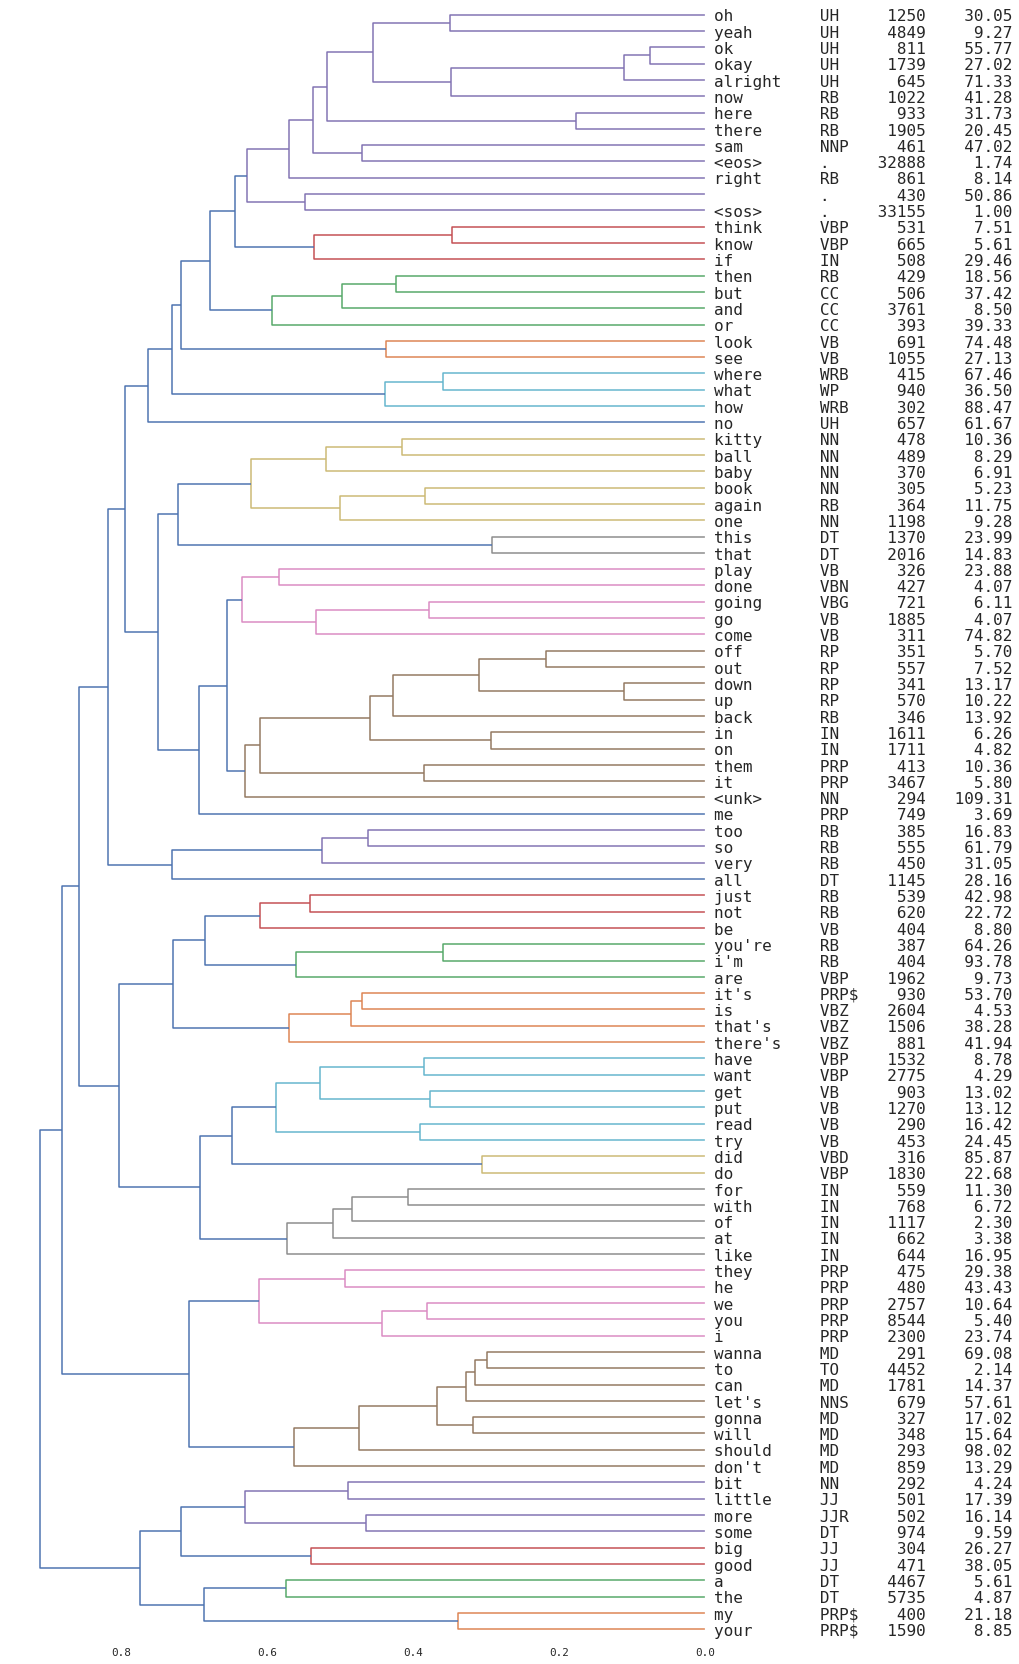

In [13]:
_ = plot_dendrogram(top_items[:100])

In [14]:
get_tsne_points(filter_items(sorted_token_items))

filtered 5229 / 5589 = 93.56% items.


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.


filtered 5229 / 5589 = 93.56% items.


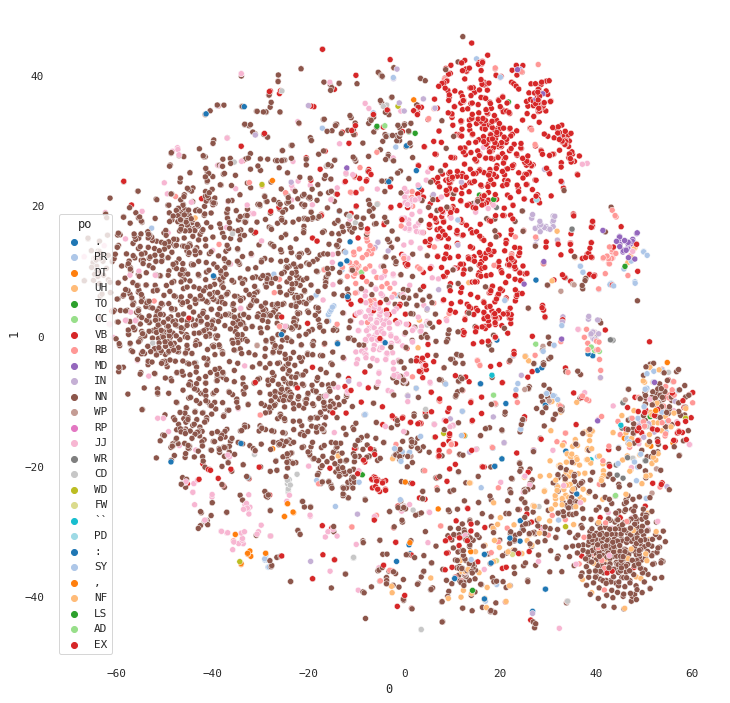

In [15]:
plot_tsne(sorted_token_items, ['po', conc_field, "AnimPhysical", "AnimMental", "Category", "AoA", "loss diff"][0], add_word=False)

/tmp/ipykernel_245483/2479437384.py:11: RuntimeWarning: invalid value encountered in true_divide
  return self.loss / self.cnt


ignored items sample: <sos> <eos> that's it's there's don't let's sam  i'm you're gonna <unk> wanna we're yea isn't here's where's yeahh we'll i'll thats uh what's theres can't they're ah he's yep doesn't that’s aren't boop didn't mm youre dont mmm bloop ohh don’t um yay hmm ruff marmite yup toby ya whats im birdy yeahhh uhhuh byebye yum mmkay nom won't where'd ahh cheep op blo you've we've heres isnt o ooh pooing woah chupey hm breaky fiona you'll ' hashbrowns doh gotta it’s s ha cuz nappie one's hmmm sam's ohhh haven't oop choo kinda ahhh jumping jerry she's
plotting 3405/5589 = 60.92% items...


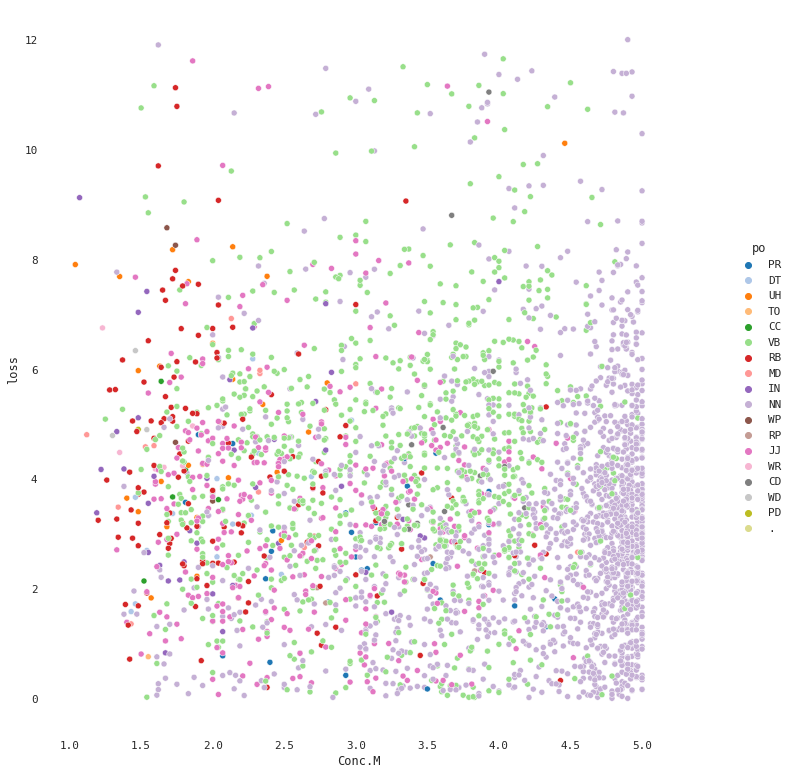

In [17]:
plot_xy([sorted_token_items, loss_diff_items[:200]][0], [conc_field, "AnimPhysical", "AoA"][0], ['loss', 'loss diff'][0], 'po', add_word=False)